# Neural Network Basics

* Feedforward neural network
* Training neural networks effectively

In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display_png
from gensim.models import word2vec, KeyedVectors
from keras.models import Sequential
from keras.layers import (
    Input, Embedding, Dense, Dropout, Flatten, GlobalAveragePooling1D, Conv1D, GlobalMaxPooling1D, BatchNormalization
)
from keras.utils import to_categorical, plot_model, pad_sequences
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from keras.models import Sequential
from keras.optimizers import Adam

In [ ]:
#import for optimizer
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras import optimizers

# Feedforward Neural Network

## 1. Load up data

In [ ]:
# load data
data = pd.read_csv('contest1_train.csv', encoding='utf-8')

# show data
data

,id,text,aspectCategory,polarity
0,3121,But the staff was so horrible to us.,service,negative
1,2777,"To be completely fair, the only redeeming fact...",food,positive
2,2777,"To be completely fair, the only redeeming fact...",anecdotes/miscellaneous,negative
3,1634,"The food is uniformly exceptional, with a very...",food,positive
4,2534,Where Gabriela personaly greets you and recomm...,service,positive
...,...,...,...,...
3151,2853,I would highly recommend this place to everyon...,anecdotes/miscellaneous,positive
3152,1163,The service is fantastic.,service,positive
3153,216,I recommend that you try this hidden spot whic...,anecdotes/miscellaneous,positive
3154,1109,The garlic mashed potatoes are hands down the ...,food,positive


In [ ]:
import nltk
nltk.download('punkt')

data['tokenized'] = data['text'].apply(lambda x: '|'.join(nltk.word_tokenize(x)))
data['length'] = data['tokenized'].apply(lambda x: x.count('|'))

data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,id,text,aspectCategory,polarity,tokenized,length
0,3121,But the staff was so horrible to us.,service,negative,But|the|staff|was|so|horrible|to|us|.,8
1,2777,"To be completely fair, the only redeeming fact...",food,positive,"To|be|completely|fair|,|the|only|redeeming|fac...",30
2,2777,"To be completely fair, the only redeeming fact...",anecdotes/miscellaneous,negative,"To|be|completely|fair|,|the|only|redeeming|fac...",30
3,1634,"The food is uniformly exceptional, with a very...",food,positive,"The|food|is|uniformly|exceptional|,|with|a|ver...",30
4,2534,Where Gabriela personaly greets you and recomm...,service,positive,Where|Gabriela|personaly|greets|you|and|recomm...,11
...,...,...,...,...,...,...
3151,2853,I would highly recommend this place to everyon...,anecdotes/miscellaneous,positive,I|would|highly|recommend|this|place|to|everyon...,11
3152,1163,The service is fantastic.,service,positive,The|service|is|fantastic|.,4
3153,216,I recommend that you try this hidden spot whic...,anecdotes/miscellaneous,positive,I|recommend|that|you|try|this|hidden|spot|whic...,13
3154,1109,The garlic mashed potatoes are hands down the ...,food,positive,The|garlic|mashed|potatoes|are|hands|down|the|...,12


ส่วนใหญ่มีแค่ 100 คำ ไม่ต้องใช้ทั้งหมด

In [ ]:
data.length.describe()

count    3156.000000
mean       15.386248
std         9.030327
min         1.000000
25%         9.000000
50%        14.000000
75%        20.000000
max        78.000000
Name: length, dtype: float64

In [ ]:
#dev.length.describe()

## 2. Load up the pre-trained word embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-02-20 17:12:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-20 17:12:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-20 17:12:37--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1k5zNhHJnXukYCtHwqNSXmwaziOX8JosX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1k5zNhHJnXukYCtHwqNSXmwaziOX8JosX
To: /content/glove.6B.100d.txt
100% 347M/347M [00:01<00:00, 189MB/s]


In [ ]:
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# create temp file and save converted embedding into it
target_file = get_tmpfile('glove.6B.200d.txt')
glove2word2vec('glove.6B.200d.txt', target_file)

# load the converted embedding into memory
model = KeyedVectors.load_word2vec_format(target_file)

# save as binary data
model.save_word2vec_format('glove.6B.200d.bin', binary=True)

In [ ]:
#load word embedding and data
w2v_model = KeyedVectors.load_word2vec_format('glove.6B.200d.bin',
                                              binary=True, unicode_errors='ignore')

In [ ]:
vocab_size = len(w2v_model.vocab)
vector_dim = w2v_model.vector_size
# make weight matrix of word embedding, vocab size + 1 (for padding)
embedding_matrix = np.zeros((vocab_size+2, vector_dim), dtype="float32")
embedding_matrix[0] = np.zeros(vector_dim)

word_to_index = {word:i+1 for i, word in enumerate(w2v_model.vocab)}
# word to index dictionary, 0 for padding, UNKNOWN
word_to_index['PADDING'] = 0
word_to_index['<UNK>'] = len(word_to_index)

for i, word in enumerate(w2v_model.vocab):
    embedding_matrix[i+1] = w2v_model[word]

In [ ]:
# vocabulary size of pre-trained model
vocab_size = len(w2v_model.vocab)
print('vocab size:', vocab_size)

vocab size: 400000


In [ ]:
# vector dimension
vector_dim = (len(w2v_model['the']))
print('vector dimension:', vector_dim)

vector dimension: 200


In [ ]:
# load data

from sklearn.model_selection import train_test_split
X = data.drop('aspectCategory', axis=1).values
y = data['aspectCategory'].values
# Assuming X contains the input features and y contains the corresponding labels
# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
train_x, dev_x, train_y, dev_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Print the size of each subset
print(f"Training set size: {len(train_x)}")
print(f"Validation set size: {len(dev_x)}")
print(f"Test set size: {len(test_x)}")


Training set size: 2019
Validation set size: 505
Test set size: 632


In [ ]:
train, dev_test = train_test_split(data, train_size=0.8, random_state=42)
dev, test = train_test_split(dev_test, test_size=0.2, random_state=42)

print(f"Training set size: {len(train)}")
print(f"Validation set size: {len(dev)}")
print(f"Test set size: {len(test)}")

Training set size: 2524
Validation set size: 505
Test set size: 127


In [ ]:
test['aspectCategory'].value_counts()

food                       52
anecdotes/miscellaneous    37
ambience                   18
service                    10
price                      10
Name: aspectCategory, dtype: int64

In [ ]:
test['polarity'].value_counts()

positive    83
negative    19
neutral     19
conflict     6
Name: polarity, dtype: int64

In [ ]:
test

,id,text,aspectCategory,polarity
1251,3489,"As much as I like the food there, I can't brin...",anecdotes/miscellaneous,negative
1480,1370,I'm still mad that i had to pay for lousy food.,food,negative
2713,2493,Overall a worthwhile experience.,anecdotes/miscellaneous,positive
2490,2997,Delicious crab cakes too.,food,positive
324,345,The service is awful.,service,negative
...,...,...,...,...
1956,2125,"Largest and freshest pieces of sushi, and deli...",food,positive
2149,2388,That's good and bad.,anecdotes/miscellaneous,conflict
449,2140,Hurley's is like Cheers where everyone knows y...,service,positive
2611,1786,The spicy Tuna roll is huge and probably the b...,price,positive


## 3. Convert words into indices and pad + truncate sequences

In [ ]:
def convert_words(df, word_to_index, max_length):
  tokens = df['tokenized'].apply(lambda x: x.split('|'))
  list_of_list_of_indices = list(tokens.map(lambda x: [word_to_index.get(word, word_to_index['<UNK>']) for word in x]))
  return pad_sequences(list_of_list_of_indices, max_length, padding='post', value=word_to_index['PADDING'], truncating='post')

# max length (กำหนดเอง)
max_len = 100
train_x = convert_words(train, word_to_index, max_len)
dev_x = convert_words(dev, word_to_index, max_len)
num_classes = 5

## 4. Mapping labels

In [ ]:
def get_label(df):
  star_to_label = {'ambience':0, 'anecdotes/miscellaneous':1, 'food':2, 'price':3, 'service':4}
  # apply functions & convert to np.array
  label = np.array(df['aspectCategory'].replace(star_to_label).tolist())
  df['label'] = label
  return to_categorical(label, num_classes=5)

# label : one-hot vector
train_y = get_label(train)
dev_y = get_label(dev)

In [ ]:
# check the shape
print('input train:', train_x.shape)
print('input dev:', dev_x.shape)
print('label train:', train_y.shape)
print('label dev:',dev_y.shape)

input train: (2524, 100)
input dev: (505, 100)
label train: (2524, 5)
label dev: (505, 5)


## 5. Train the model

## Deep Average Net

In [ ]:
def make_deep_average_net(print_model=True):
    # instantiation
    model = Sequential()

    # add embedding layer
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        input_length=max_len,
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        mask_zero=True,
                        trainable=False))

    model.add(BatchNormalization())

    # average
    model.add(GlobalAveragePooling1D())

    # add hidden layer
    model.add(Dense(100, activation='relu'))

    model.add(Dropout(0.3))

    model.add(Dense(100, activation='relu'))

    model.add(Dropout(0.5))

    # add output layer
    model.add(Dense(num_classes, activation='softmax'))

    lr = 0.001
    optimizer = Adam(lr=lr)

    # compile model
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
    if print_model:
        model.summary()
        plot_model(model, show_shapes=True,to_file='model.png')
        display_png(Image('model.png'))
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          80000400  
                                                                 
 batch_normalization (BatchN  (None, 100, 200)         800       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 200)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


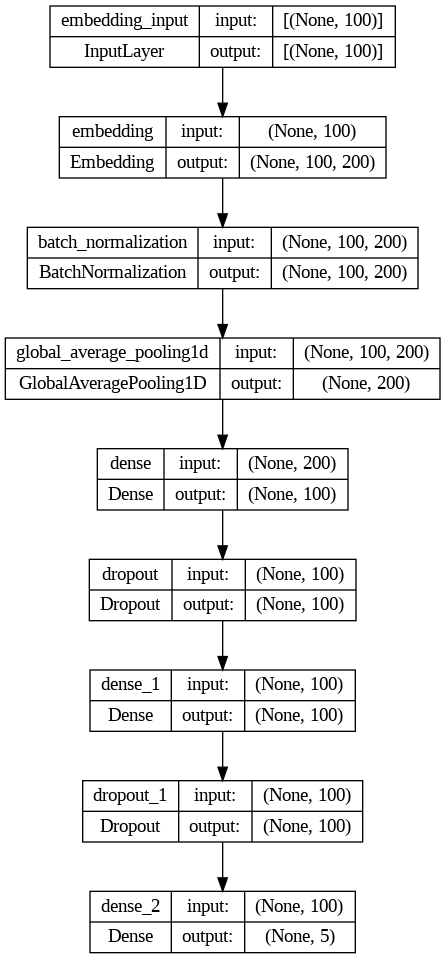

In [ ]:
model = make_deep_average_net()

In [ ]:
# train
history = model.fit(train_x, train_y, batch_size=64, epochs=8, validation_data=(dev_x, dev_y))

Epoch 1/8
40/40 [==============================] - 2s 16ms/step - loss: 1.5286 - accuracy: 0.3831 - val_loss: 1.5052 - val_accuracy: 0.5287
Epoch 2/8
40/40 [==============================] - 0s 10ms/step - loss: 1.2824 - accuracy: 0.4992 - val_loss: 1.4511 - val_accuracy: 0.5525
Epoch 3/8
40/40 [==============================] - 0s 10ms/step - loss: 1.1731 - accuracy: 0.5523 - val_loss: 1.3589 - val_accuracy: 0.5921
Epoch 4/8
40/40 [==============================] - 0s 10ms/step - loss: 1.0882 - accuracy: 0.5784 - val_loss: 1.2712 - val_accuracy: 0.6059
Epoch 5/8
40/40 [==============================] - 0s 11ms/step - loss: 1.0310 - accuracy: 0.6010 - val_loss: 1.1917 - val_accuracy: 0.6436
Epoch 6/8
40/40 [==============================] - 0s 11ms/step - loss: 0.9915 - accuracy: 0.6189 - val_loss: 1.1268 - val_accuracy: 0.6040
Epoch 7/8
40/40 [==============================] - 0s 11ms/step - loss: 0.9444 - accuracy: 0.6335 - val_loss: 1.0662 - val_accuracy: 0.6515
Epoch 8/8
40/40 [===

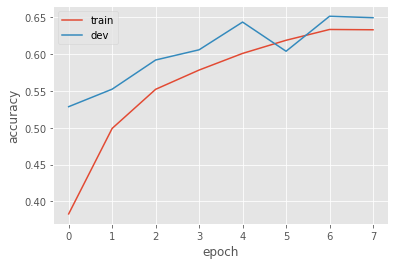

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

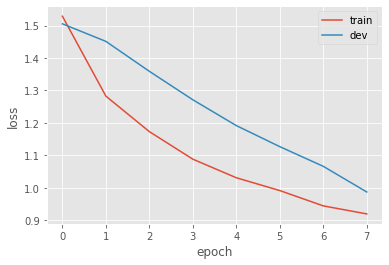

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

## 6. Evaluate the model

In [ ]:
prediction = [np.argmax(x) for x in model.predict(dev_x)]
print(classification_report(dev['label'], prediction))

16/16 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.58      0.33      0.42        54
           1       0.66      0.85      0.74       149
           2       0.68      0.75      0.71       174
           3       0.54      0.30      0.39        43
           4       0.60      0.46      0.52        85

    accuracy                           0.65       505
   macro avg       0.61      0.54      0.56       505
weighted avg       0.64      0.65      0.63       505



## CNN

In [ ]:
def make_cnn_model(print_model=True):
    filters = 300 #number of filters in your Convnet
    kernel_size = 3 # a window size of 3 tokens
    hidden_dims = 100 #number of neurons at the normal feedforward NN

    cnn_model = Sequential()
    cnn_model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        input_length=max_len,
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        mask_zero=True,
                        trainable=False))

    cnn_model.add(Conv1D(filters,
                        kernel_size,
                        input_shape=(max_len, embedding_matrix.shape[1]),
                        activation='relu',))

    cnn_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))

    cnn_model.add(GlobalMaxPooling1D())
    #GlobalMaxPooling1D(n) default = 2.
    cnn_model.add(Dense(hidden_dims, activation='relu'))
    cnn_model.add(Dropout(0.4))
    cnn_model.add(Dense(5, activation='softmax'))

    # compile model
    cnn_model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy", metrics=["accuracy"])
    if print_model:
        cnn_model.summary()
        plot_model(cnn_model, show_shapes=True,to_file='model.png')
        display_png(Image('model.png'))
    return cnn_model

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 200)          80000400  
                                                                 
 conv1d_9 (Conv1D)           (None, 98, 300)           180300    
                                                                 
 dense_30 (Dense)            (None, 98, 64)            19264     
                                                                 
 global_max_pooling1d_9 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_31 (Dense)            (None, 100)               6500      
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                     

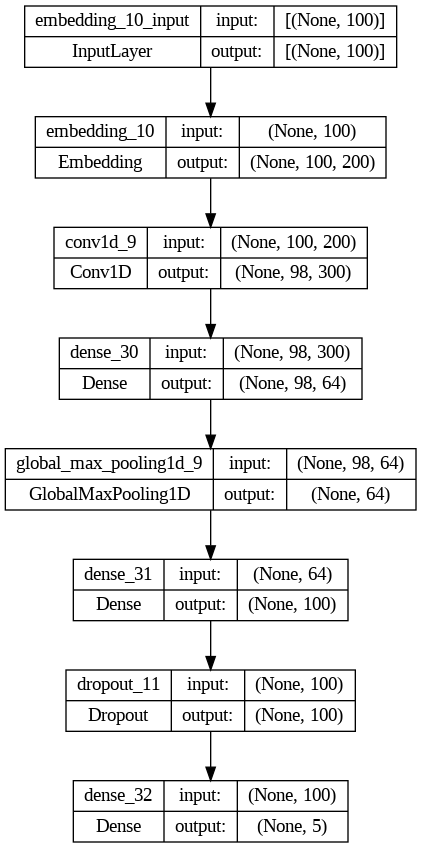

In [ ]:
cnn_model = make_cnn_model()

In [ ]:
# train
cnn_history = cnn_model.fit(train_x, train_y, batch_size=128, epochs=7, validation_data=(dev_x, dev_y))

Epoch 1/7
20/20 [==============================] - 5s 220ms/step - loss: 2.2176 - accuracy: 0.4881 - val_loss: 1.8863 - val_accuracy: 0.5921
Epoch 2/7
20/20 [==============================] - 3s 175ms/step - loss: 1.7257 - accuracy: 0.6141 - val_loss: 1.6374 - val_accuracy: 0.6198
Epoch 3/7
20/20 [==============================] - 3s 174ms/step - loss: 1.4750 - accuracy: 0.6561 - val_loss: 1.4349 - val_accuracy: 0.6475
Epoch 4/7
20/20 [==============================] - 4s 201ms/step - loss: 1.3073 - accuracy: 0.6811 - val_loss: 1.3192 - val_accuracy: 0.6515
Epoch 5/7
20/20 [==============================] - 3s 168ms/step - loss: 1.1823 - accuracy: 0.6910 - val_loss: 1.2581 - val_accuracy: 0.6139
Epoch 6/7
20/20 [==============================] - 3s 171ms/step - loss: 1.0938 - accuracy: 0.6997 - val_loss: 1.2162 - val_accuracy: 0.6515
Epoch 7/7
20/20 [==============================] - 3s 171ms/step - loss: 1.0356 - accuracy: 0.7072 - val_loss: 1.1541 - val_accuracy: 0.6455


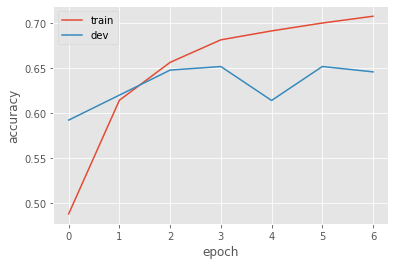

In [ ]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

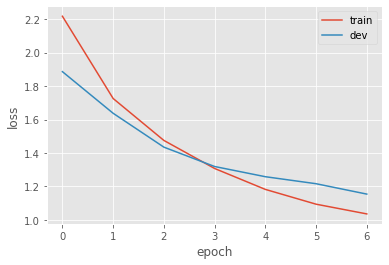

In [ ]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [ ]:
prediction = [np.argmax(x) for x in cnn_model.predict(dev_x)]
print(classification_report(dev['label'], prediction))

16/16 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       0.46      0.48      0.47        54
           1       0.71      0.83      0.77       149
           2       0.65      0.80      0.72       174
           3       0.43      0.30      0.36        43
           4       0.68      0.22      0.34        85

    accuracy                           0.64       505
   macro avg       0.59      0.53      0.53       505
weighted avg       0.63      0.64      0.61       505



In [ ]:
cnn_model.evaluate(dev_x, dev_y)[1]

16/16 [==============================] - 0s 20ms/step - loss: 1.1760 - accuracy: 0.6376


0.6376237869262695

## Hyperparameter

In [ ]:
from keras import optimizers, regularizers
model.compile(optimizer=optimizers.Adagrad(learning_rate=0.001),
              loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
Dense(250, activation='relu',
      kernel_regularizer=regularizers.l2(l2=1e-5),
      bias_regularizer=regularizers.l2(1e-5))

In [ ]:
model.add(Dropout(0.4))